In [12]:
# Import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [10]:
# Define variables to load data
base_paths = {
    'train': '../../data/processed/train/',
    'test': '../../data/processed/test/',
    'val': '../../data/processed/val/'
}

image_size = (224, 224)
batch_size = 32

In [11]:
# Load the data
data = {}
for split, path in base_paths.items():
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory=path,
        labels=None,  # We don't need labels for unsupervised learning
        color_mode='grayscale', 
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True,  
        seed=42  
    )
    # Normalize images between [0, 1]
    dataset = dataset.map(lambda x: x / 255.0)
    data[split] = dataset
    print(f"{split} - Dataset created")

Found 125 files belonging to 1 classes.
train - Dataset created
Found 27 files belonging to 1 classes.
test - Dataset created
Found 27 files belonging to 1 classes.
val - Dataset created


In [ ]:
# Define function to show sample images
def plot_sample_images(dataset, split_name, num_samples=5):
    """Plot sample images from the dataset."""
    iterator = iter(dataset)
    images = next(iterator).numpy() 
    
    plt.figure(figsize=(10, 5))
    for i in range(min(num_samples, len(images))):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Img {i+1}")
        plt.axis('off')
    plt.show()

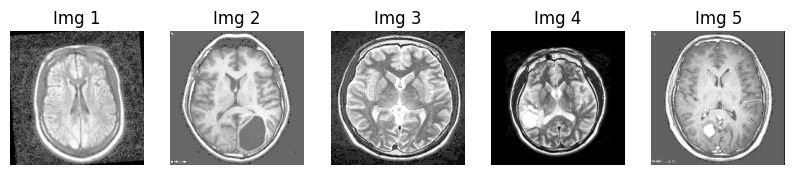

In [ ]:
# Plot sample images from the training dataset
plot_sample_images(data['train'], 'train', num_samples=5)

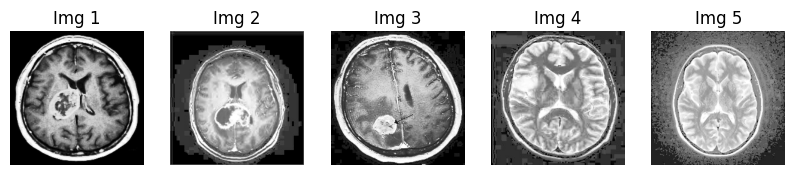

In [ ]:
# Plot sample images from the validating dataset
plot_sample_images(data['val'], 'val', num_samples=5)

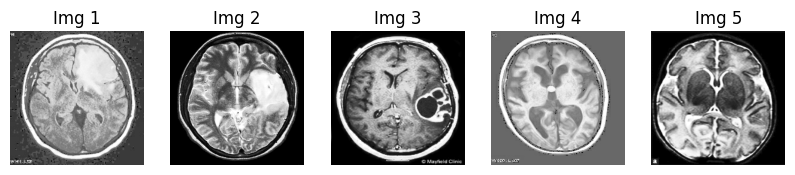

In [16]:
# Plot sample images from the testing dataset
plot_sample_images(data['test'], 'test', num_samples=5)

## Define Autoencoder model

In [17]:
# Define function for noise reduction
def add_noise(images):
    noise_factor = 0.2  
    noisy_images = images + noise_factor * tf.random.normal(tf.shape(images))
    noisy_images = tf.clip_by_value(noisy_images, 0.0, 1.0) 
    return noisy_images

data_noisy = {split: dataset.map(lambda x: (add_noise(x), x)) for split, dataset in data.items()}

In [19]:
# Define the autoencoder model
inputs = tf.keras.Input(shape=(224, 224, 1))

In [20]:
# Encoder
e1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(inputs)
e2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(e1)
e3 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)(e2)

In [21]:
# Decoder
d1 = tf.keras.layers.Conv2DTranspose(8, (3, 3), activation='relu', padding='same', strides=2)(e3)
d2 = tf.keras.layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=2)(d1)
d3 = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(d2)

In [22]:
# Output layer
outputs = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d3)

In [23]:
# Create the autoencoder model
autoencoder = tf.keras.Model(inputs=inputs, outputs=outputs)

In [35]:
# Compile the model
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
autoencoder.compile(optimizer='adam', loss='mse')

In [36]:
# Summarize the model
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      320       
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 16)        4624      
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 8)         1160      
                                                                 
 conv2d_transpose (Conv2DTr  (None, 56, 56, 8)         584       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 112, 112, 16)      1168      
 Transpose)                                                  

In [37]:
# Train the autoencoder model
history = autoencoder.fit(
    data_noisy['train'],
    epochs=10,
    validation_data=data_noisy['val']
)

Epoch 1/10
4/4 [==============================] - 11s 2s/step - loss: 0.0443 - val_loss: 0.0359
Epoch 2/10
4/4 [==============================] - 8s 2s/step - loss: 0.0358 - val_loss: 0.0288
Epoch 3/10
4/4 [==============================] - 8s 2s/step - loss: 0.0294 - val_loss: 0.0249
Epoch 4/10
4/4 [==============================] - 8s 2s/step - loss: 0.0257 - val_loss: 0.0230
Epoch 5/10
4/4 [==============================] - 8s 2s/step - loss: 0.0237 - val_loss: 0.0218
Epoch 6/10
4/4 [==============================] - 8s 2s/step - loss: 0.0220 - val_loss: 0.0202
Epoch 7/10
4/4 [==============================] - 8s 2s/step - loss: 0.0205 - val_loss: 0.0191
Epoch 8/10
4/4 [==============================] - 7s 2s/step - loss: 0.0193 - val_loss: 0.0181
Epoch 9/10
4/4 [==============================] - 7s 2s/step - loss: 0.0183 - val_loss: 0.0172
Epoch 10/10
4/4 [==============================] - 8s 2s/step - loss: 0.0174 - val_loss: 0.0164


In [43]:
# Test loss evaluation
test_loss = autoencoder.evaluate(data_noisy['test'], verbose=0)
print(f"Loss (MSE) in test dataset: {test_loss:.6f}")

Loss (MSE) in test dataset: 0.015821


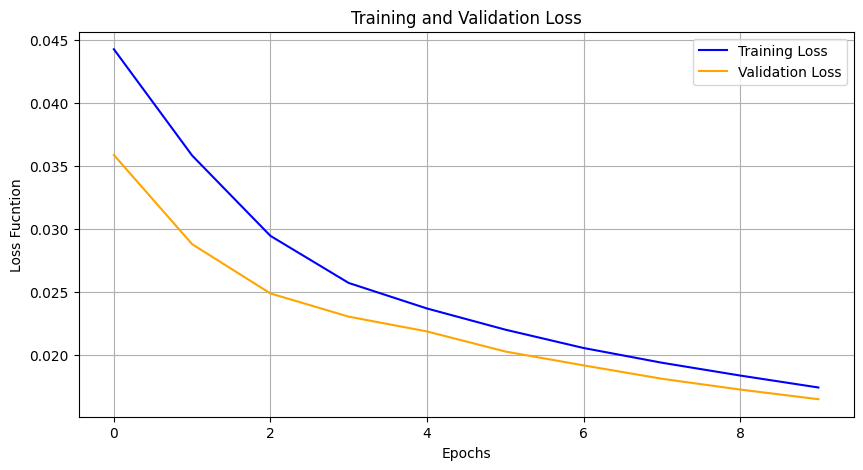

In [39]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss Fucntion')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
# Define function to visualize the denoising process
def plot_reconstructions(model, dataset, num_samples=5):
    for noisy_images, original_images in dataset.take(1):
        reconstructions = model.predict(noisy_images)
        plt.figure(figsize=(15, 9))
        for i in range(min(num_samples, noisy_images.shape[0])):
            plt.subplot(3, num_samples, i + 1)
            plt.imshow(original_images[i].numpy().squeeze(), cmap='gray')
            plt.title('Original')
            plt.axis('off')
        
            plt.subplot(3, num_samples, i + num_samples + 1)
            plt.imshow(noisy_images[i].numpy().squeeze(), cmap='gray')
            plt.title('Noisy')
            plt.axis('off')
            
            plt.subplot(3, num_samples, i + 2 * num_samples + 1)
            plt.imshow(reconstructions[i].squeeze(), cmap='gray')
            plt.title('Denoised')
            plt.axis('off')
        plt.show()

1/1 [==============================] - 1s 570ms/step


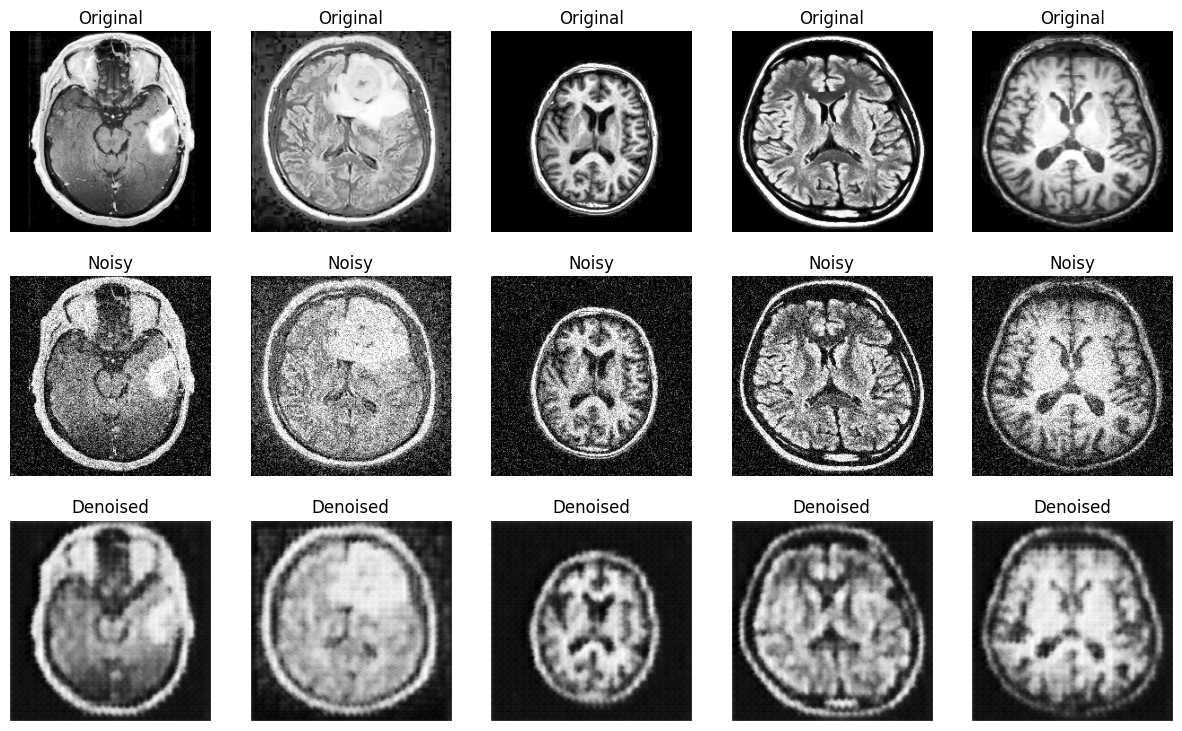

In [42]:
# Plot the denoising process for the validation set
plot_reconstructions(autoencoder, data_noisy['val'])